FACTS: <br>
Number of images in training set: N = 416 <br>
Number of Pixels per image: D = 2576 <br>
Number of classes: c = 52 <br>
-> <br>
Sw: rank(Sw)= N-c = 364 -> Mpca <= 364 <br>
Sb: rank(Sb)= c-1 = 51 -> Mlda <= 51 <br>

In [1]:
# Imports
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Load the source file with the face data
mat_content = sio.loadmat('face.mat')

In [2]:
# Store face data and classification
face_data = mat_content['X']
face_label = mat_content['l'] # Not actually used for PCA training, needed for testing

# Append the matching data and labels into array 'faces': unnecessary for PCA training as the labels are not used (unsupervised learning)
# But we need it later for assessing our algorithms during testing
faces = np.append(face_data, face_label, axis=0)

#Transpose in preparation for division into training and testing material
faces_transposed = faces.T

In [3]:
#create training data by sampling over each class
test_class = np.zeros((104,2577))
train_class = np.zeros((416,2577))
for i in range(52):
    temp_class_set = faces_transposed[i==(faces_transposed[:,-1]-1),:]
    np.random.shuffle(temp_class_set)
    train_class[8*i:(8*i)+8,:] = temp_class_set[:8,:]
    test_class[2*i:(2*i)+2,:]=temp_class_set[8:,:]
    
print(train_class, train_class.shape)
print(test_class, test_class.shape)

[[191. 185. 174. ...  19.  17.   1.]
 [ 96.  93.  95. ...  85. 121.   1.]
 [ 93.  95.  81. ... 100.  91.   1.]
 ...
 [176. 174. 164. ... 149. 140.  52.]
 [ 27.  29.  30. ... 127. 181.  52.]
 [188. 186. 195. ...  62.  58.  52.]] (416, 2577)
[[ 73.  83. 124. ...  30.  26.   1.]
 [106. 103. 103. ...  36.  41.   1.]
 [130. 133. 124. ...  60.  47.   2.]
 ...
 [196. 194. 192. ...  22.  22.  51.]
 [ 70.  62.  83. ...  89.  94.  52.]
 [183. 250. 163. ...  95. 106.  52.]] (104, 2577)


In [4]:
#Divide the data set into training and testing sets: 80% is training, 20% is testing
np.random.shuffle(faces_transposed) # Shuffle the rows (This is why we transposed)
#training, test = faces_transposed[:416,:], faces_transposed[416:,:]

#make use of new test and training data
training=train_class
test = test_class

training, testing: axis 0: pictures, axis 1: pixels + label

In [5]:
#order training data depending on their class
training = training[np.argsort(training[:,-1]),:]

# Create a list of arrays depending on the classes
class_sets = []
for i in range(52):
    class_sets.append(training[i==(training[:,-1]-1),:2576])
    
print(class_sets[0],class_sets[0].shape)

# Calculate the class means
#class_means = []
#for c in class_sets:
#    class_means.append(np.mean(c, axis=0))
#print(class_means[0],class_means[0].shape)

class_means = np.zeros((52,2576))
for i in range(52):
    class_means[i,:] = np.mean(class_sets[i], axis=0)

# Calculate the global mean
global_mean = np.mean(training[:,:2576], axis=0)
print(global_mean,global_mean.shape)

#Calculate Sb
class_means_norm = class_means - global_mean #make us of broadcasting
Sb = np.dot(class_means_norm.T, class_means_norm)
#print(np.linalg.matrix_rank(Sb)) # =c-1


[[191. 185. 174. ...  22.  19.  17.]
 [ 96.  93.  95. ... 100.  85. 121.]
 [ 93.  95.  81. ...  88. 100.  91.]
 ...
 [ 65.  66.  65. ...  62.  75.  84.]
 [ 66.  72.  67. ... 167. 166. 163.]
 [161. 162. 160. ...  50.  47.  46.]] (8, 2576)
[123.34134615 123.09134615 120.10817308 ...  86.52163462  85.1875
  83.85336538] (2576,)


In [6]:
#Calculate x-mi
class_sets_norm = []
for i in range(52):
    class_sets_norm.append(class_sets[i]-class_means[i,:])
print(class_sets_norm[0].shape)

(8, 2576)


In [7]:
#Calculate Sw
Sw = np.zeros((2576,2576))
for c in class_sets_norm:
    Sw += np.dot(c.T,c)
    
#print(np.linalg.matrix_rank(Sw)) # = N-c

In [8]:
#Calculate St
# Images are represented as rows of the array 'pca_train'
pca_train = training [:, :2576]
pca_train_norm = pca_train - global_mean
St = np.dot(pca_train_norm.T, pca_train_norm)

In [9]:
# Calculate Wpca
eigvals_St, eigvecs_St = np.linalg.eig(St)

# take real part of the eigenvalues (complex eigenvalues are the result of calculation rounding errors)
eigvals_St = np.real(eigvals_St)
eigvecs_St = np.real(eigvecs_St)

#order eigenvectors and eigenvalues according to their size
index_St = eigvals_St.argsort()[::-1]
eigvals_St = eigvals_St[index_St]
eigvecs_St = eigvecs_St[:,index_St]

# We just keep the first n eigenvectors and eigenvalues
Mpca = 350 #<=364
eigvecs_St_best = eigvecs_St[:, :Mpca]
eigvals_St_best = eigvals_St[:Mpca]

#Define Wpca
Wpca = eigvecs_St_best

print(Wpca, Wpca.shape)

[[-0.01241571 -0.01873676 -0.01570035 ... -0.00848411  0.00348115
  -0.00692985]
 [-0.01376414 -0.01786878 -0.0162354  ...  0.00256262 -0.04914173
   0.03618909]
 [-0.01483126 -0.01707531 -0.01748848 ...  0.0480787  -0.01483602
  -0.02768748]
 ...
 [ 0.00707679  0.04921009 -0.00373016 ... -0.0002207  -0.02355313
   0.09020419]
 [ 0.0081208   0.04919289 -0.00395102 ...  0.01140227  0.01050511
   0.06043425]
 [ 0.0079928   0.05018298 -0.00155407 ...  0.01576721  0.01282209
   0.04281286]] (2576, 350)


In [10]:
#calculate inverse of Sw_reduced times Sb_reduced
LDA = np.linalg.inv(Wpca.T.dot(Sw).dot(Wpca)).dot(Wpca.T.dot(Sb).dot(Wpca))

print(LDA, LDA.shape)

[[ 2.35516319e+01 -4.57044798e-01  5.10360701e+00 ...  2.79084675e-02
  -5.27136008e-02  6.02396113e-05]
 [-8.13027329e-01  7.98715048e+00 -2.45243185e+00 ... -4.26901844e-02
   2.16229890e-02 -8.51260483e-03]
 [ 1.13822498e+01 -3.07469090e+00  9.19636392e+00 ...  2.00022995e-02
  -1.67900337e-02 -1.93032302e-03]
 ...
 [ 9.78517900e+01 -8.41423123e+01  3.14457402e+01 ...  1.13645081e+00
  -7.84573576e-01  9.91684609e-02]
 [-1.86241363e+02  4.29460091e+01 -2.65983157e+01 ... -7.90595522e-01
   1.35906999e+00 -2.98869678e-02]
 [ 2.14577950e-01 -1.70458644e+01 -3.08306039e+00 ...  1.00749690e-01
  -3.01322338e-02  4.09153301e-01]] (350, 350)


[ 1.76660159e+02  1.58181060e+02  9.06650768e+01  5.46939081e+01
  3.75428233e+01  3.15240953e+01  3.10506108e+01  2.47654031e+01
  2.20202082e+01  1.79718917e+01  1.51784783e+01  1.45174920e+01
  1.29149854e+01  1.18086202e+01  1.06779264e+01  1.02712196e+01
  8.67715397e+00  7.50530215e+00  5.99779033e+00  5.71493755e+00
  5.12364217e+00  5.02271121e+00  4.37289991e+00  4.02349915e+00
  3.23410831e+00  3.04275059e+00  2.94408525e+00  2.72108284e+00
  2.68188088e+00  2.46021249e+00  2.16983764e+00  1.97270271e+00
  1.87036664e+00  1.76469367e+00  1.52662787e+00  1.37534325e+00
  1.31429458e+00  1.22394369e+00  1.11336247e+00  1.02325210e+00
  9.09798888e-01  8.62715650e-01  8.23110868e-01  6.56422467e-01
  6.32225075e-01  5.91991566e-01  5.37426896e-01  4.65284157e-01
  4.24241947e-01  3.39574966e-01  3.03996931e-01  1.47860843e-14
  1.47860843e-14  1.07179224e-14  1.07179224e-14  1.02570858e-14
  1.02570858e-14  8.95220368e-15  8.95220368e-15  6.98634878e-15
  6.98634878e-15  6.91889

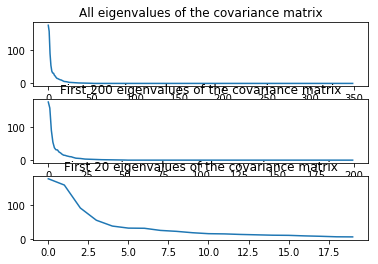

[[-0.01510825  0.00358137  0.0063988  ... -0.00062128  0.00134457
  -0.00182815]
 [ 0.00481263  0.01036138 -0.00204163 ...  0.00563237  0.00046791
   0.00233026]
 [-0.01055178  0.00081649  0.00894476 ...  0.00058572  0.00438261
   0.00030691]
 ...
 [-0.14618865 -0.14686686  0.04281386 ...  0.00162503 -0.10384685
   0.00444415]
 [ 0.22136219  0.02628913  0.07015674 ... -0.02964901 -0.07692464
   0.04732832]
 [-0.00022776 -0.04100678 -0.04350073 ...  0.06049035 -0.12094082
  -0.02922364]] (350, 50)


In [11]:
#calculate Wlda
#Get the generalised eigenvectors of LDA_matrix with largest Mlda eigenvalues
eigvals_LDA, eigvecs_LDA = np.linalg.eig(LDA)

# take real part of the eigenvalues (complex eigenvalues are the result of calculation rounding errors)
eigvals_LDA = np.real(eigvals_LDA)
eigvecs_LDA = np.real(eigvecs_LDA)

#order eigenvectors and eigenvalues according to their size
index_LDA = eigvals_LDA.argsort()[::-1]
eigvals_LDA = eigvals_LDA[index_LDA]
eigvecs_LDA = eigvecs_LDA[:,index_LDA]

x = np.arange(0, 350)
print (eigvals_LDA, eigvals_LDA.shape)

# plot them
plt.subplot(3, 1, 1)
plt.plot(x, eigvals_LDA) # clearly out of scale, so let's just take the first 200 of them
plt.title('All eigenvalues of the covariance matrix')

plt.subplot(3, 1, 2)
plt.plot(x[:200], eigvals_LDA[:200]) # still out of scale, so let's just take the first 20 of them
plt.title('First 200 eigenvalues of the covariance matrix')

plt.subplot(3, 1, 3)
plt.plot(x[:20], eigvals_LDA[:20])
plt.title('First 20 eigenvalues of the covariance matrix')
plt.show()

# We just keep the first Mlda eigenvectors and eigenvalues
Mlda = 50 #<=51
eigvecs_LDA_best = eigvecs_LDA[:, :Mlda]
eigvals_LDA_best = eigvals_LDA[:Mlda]

#Define Wpca
Wlda = eigvecs_LDA_best

print(Wlda, Wlda.shape)

[[ 0.02172858 -0.00755319  0.00939366 ... -0.02636943 -0.02264566
  -0.01979938]
 [-0.02417494 -0.01208756 -0.01069084 ... -0.00305427 -0.02878624
  -0.01562797]
 [ 0.02779114 -0.0167707  -0.0066237  ... -0.03189462 -0.04656201
  -0.00421013]
 ...
 [ 0.03807641 -0.02388351 -0.00576221 ...  0.00894045 -0.03714128
   0.00419491]
 [ 0.00268097  0.00179315 -0.00581883 ... -0.00581384  0.00027419
  -0.01106839]
 [-0.02110172  0.00271772  0.05181026 ... -0.05717241 -0.03828591
   0.00192976]] (50, 2576)


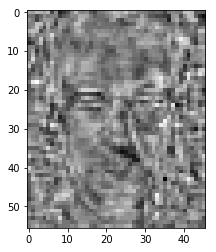

In [12]:
#Calculate Wopt
Wopt_transposed = Wlda.T.dot(Wpca.T)
print(Wopt_transposed,Wopt_transposed.shape)
Wopt = Wopt_transposed.T
plt.imshow(np.reshape(Wopt[:,0], (46,56)).T, cmap = 'gist_gray')

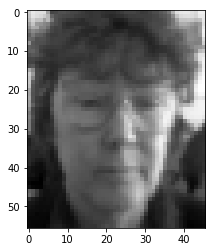

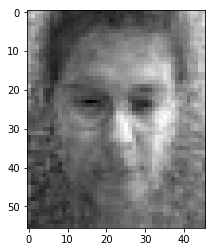

In [13]:
#Reconstruction check
plt.imshow(np.reshape(pca_train[0,:], (46,56)).T, cmap = 'gist_gray')
pic_LDA = Wopt_transposed.dot((pca_train[0,:]-global_mean))
pic_LDA_reconstructed = Wopt.dot(pic_LDA)+global_mean
plt.figure()
plt.imshow(np.reshape(pic_LDA_reconstructed, (46,56)).T, cmap = 'gist_gray')

(2576, 416)
(50, 416)
(2576, 104)
(50, 104)
(416, 104)
[122   5  12  11  20  24  25  26  38 122  42  47  52  52  56  61  65  68
  73  76  84  86  94  94  99 102 111 106 118 118 122 122 128  27 141 138
 144 145 153 153 161 161 190 168 179 179  24 191 193 196 204 203 212 282
  61 216 227 224 236 234 245 245 255 255 263 260 269 122  27 276 227 282
 295 293 297 296 305 305 312 315 327 327 335 331 341 343 348 122 355 355
 363 122 113 374 383 382 385 385 395 393 402 403 122 122]
[[1 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 0]]


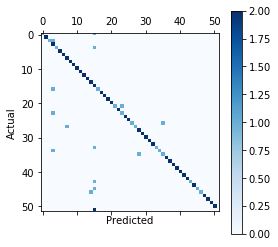

Percentage:  0.8461538461538461


In [14]:
#Predict the class for the test set
#Project train data into LDA space
train_norm = (training[:,:2576] - global_mean).T 
print(train_norm.shape) #each picture is a column
train_LDA = Wopt_transposed.dot(train_norm)
print(train_LDA.shape) #each picture is a column

#Project test data into LDA space
test_norm = (test[:,:2576] - global_mean).T 
print(test_norm.shape) #each picture is a column
test_LDA = Wopt_transposed.dot(test_norm)
print(test_LDA.shape) #each picture is a column

train_LDA_reshape_1 = np.repeat(train_LDA.reshape(Mlda,416,1),104, axis=2) #axis-0: projected values, axis-1: training pictures, axis-2: repeated values
test_LDA_reshape_1 = np.repeat(test_LDA.reshape(Mlda,1,104), 416, axis=1) #axis-0: projected values, axis-1: repeated values, axis-2: test pictures

#Do nearest neighbours
distances = np.linalg.norm(test_LDA_reshape_1-train_LDA_reshape_1, axis=0)
print(distances.shape)

#calculate the nearest training picture
nearest_trainpicture = distances.argmin(axis=0)
print(nearest_trainpicture)

#determine the nearest classes
classes_pred = training[nearest_trainpicture,2576]
classes_act = test[:,2576]

cm = confusion_matrix(classes_act, classes_pred)

print(cm)
plt.matshow(cm, cmap = 'Blues')
plt.colorbar()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

percentage = np.sum(classes_pred==classes_act) / len(classes_act)
print("Percentage: ",percentage)


In [15]:
#Predict the class for the test set (average nearest neighbours)
#Project all classes into the LDA-Space
class_sets_LDA = []
for c in class_sets:
    class_sets_LDA.append(Wopt_transposed.dot((c-global_mean).T))
print(class_sets_LDA[0], class_sets_LDA[0].shape)

#calculate the average distance to the class
class_mean_distance = np.zeros((52,104))
for i in range(52):
    train_LDA_reshape_2 = np.repeat(class_sets_LDA[i].reshape(Mlda,class_sets_LDA[i].shape[1],1),104,axis=2)
    test_LDA_reshape_2 = np.repeat(test_LDA.reshape(Mlda,1,104), class_sets_LDA[i].shape[1], axis=1)
    d = np.linalg.norm(test_LDA_reshape_2-train_LDA_reshape_2, axis=0)
    class_mean_distance[i,:]=np.average(d,axis=0)
    
#class_mean_distance is a matrix where each element stores the mean class difference of a test point to a certain class
#axis-0: classes, axis-1: mean distance for each point
print(class_mean_distance.shape)



[[-32.44902192 -32.57534265 -34.09255848 -33.47966201 -32.36741089
  -33.7601359  -33.30543291 -33.50088686]
 [ 73.20021946  74.66996846  74.79722956  75.19708414  75.55638367
   74.9384917   74.50197731  75.55906408]
 [-32.62068415 -30.43719468 -29.73843035 -28.01205865 -31.18312774
  -28.61892791 -30.4824592  -28.80014559]
 [  5.67825527   7.61606651   8.36614514  11.20129598   9.37533235
    8.88748328   8.46115328   7.51580009]
 [ 69.61164992  70.56921088  70.79922845  73.67792358  70.47865888
   67.84345337  68.42890642  71.29286128]
 [-29.18636592 -30.20650619 -31.70752797 -30.51302024 -32.14376808
  -29.98941463 -30.98569534 -33.37420824]
 [-60.4199785  -60.90665922 -60.01930599 -59.01458701 -61.09153988
  -57.24946291 -62.68916821 -59.79128007]
 [-83.23605    -88.43867415 -87.43111089 -87.99981997 -90.71181359
  -92.50016428 -87.37637137 -90.63973594]
 [-63.8708611  -54.51084124 -55.56467016 -49.8089021  -55.05573112
  -50.14763838 -58.06574603 -55.96418503]
 [  7.30270629   4.

[[2 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 2]]


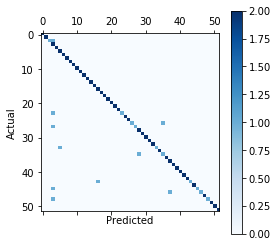

Percentage:  0.9038461538461539


In [16]:
#determine the nearest classes
classes_pred_1 = class_mean_distance.argmin(axis=0)+1 #python index starts from 0 -> add 1
classes_act_1 = test[:,2576]

cm = confusion_matrix(classes_act_1, classes_pred_1)

print(cm)
plt.matshow(cm, cmap = 'Blues')
plt.colorbar()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

percentage_1 = np.sum(classes_pred_1==classes_act_1) / len(classes_act_1)
print("Percentage: ",percentage_1)